### 1) Import all necessary libraries

In [1]:
# Import packages from Anaconda
import pandas as pd
import numpy as np
import nltk
import re
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import mean_squared_error

C:\Users\medSr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\medSr\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 2) Bring in the data
We will start first by loading the `train`, `test`, `attributes` and `product description` files. The format of the files are in a CSV format which why we called the Pandas package. Note that Pandas purpose does not stop only at reading CSV files, it can do numerous useful jobs which we will see later in this notebook.
The purpose of the following process is to predict the relevance of the test set given id and product_uid.

Let's start.

In [2]:
train = pd.read_csv('train.csv',encoding='latin-1',index_col='id')
test = pd.read_csv('test.csv',encoding='latin-1', index_col = 'id')
attr = pd.read_csv('attributes.csv',encoding='latin-1')
pt_desc = pd.read_csv('product_descriptions.csv', encoding='latin-1')

Bellow is a snippet of the train and test sets which we will be cleaning, processing and applying machine learning models.

In [3]:
train.head()

,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
test.head()

,product_uid,product_title,search_term
id,,,
1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


Notice that the relevance column is absent from the test table. 

According to Wiki: 
> " _In machine learning, the study and construction of algorithms that can learn from and make predictions on data is a common task. Such algorithms work by making data-driven predictions or decisions through building a mathematical model from input data._"

In short, from the training set, we will train a model which will predict the missing relevance data from the test set. They are called **labels**.

## 1st Iteration

**What we need to do at first ?**

Before we start, we have to ask ourselves. What data are we be dealing with ?  is the available data meaningful?
At first impression, yes, the data seem to be in great shape; phrases that describe a specific product and its title, as well as Home Depot customers search query. However, training a machine learning model with words and phrases will not output the desired result. A human can easily read words and phrases and come up with a result,machine models, and computers in general will have a lot of difficulties doing so. Therefore, we need to change the data into a set that our models will understand. Basically, change the data into numbers.

As I said, Pandas will be helpful. Bellow we will use Pandas to concatenate the train and test data sets together and merge the result of the concatenation with the product description set. The reason we concatenated the train and test dataset together is that we want to save time and performance processing and cleaning the data without repeating the same process over on two separate blocks of code. 

In [5]:
#concatination
concat = pd.concat((train,test),axis=0)
#merging
df_merge = pd.merge(concat,pt_desc, on='product_uid', how='left')

Length of our merged data

In [6]:
len(df_merge)

240760

A look at the 5 first rows.

In [7]:
df_merge.head()

,product_title,product_uid,relevance,search_term,product_description
0,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ..."
1,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...


### Basic Features Creation

Now, we will create features which will be representing our data but in a digital format, so our models can train for an accurate prediction.

Note that our main role is to structure a pipeline so our models can predict the relevance of a query to a specific product. In the `length()` function, we will just measure the length of a `search_term`, `product_title` and `product_description`. A simple and basic approach.

In [8]:
def length(df):
    data = df.copy().astype(str)
    #search
    data['length_search_terms'] = data['search_term'].map(lambda x : len(x.split()))
    #title
    data['length_product_title'] = data['product_title'].map(lambda x :len(x.split()))
    #pt description
    data['length_product_description'] = data['product_description'].map(lambda x: len(x.split()))

    return data

In [9]:
length_attributes = length(df_merge)
length_attributes.head()

,product_title,product_uid,relevance,search_term,product_description,length_search_terms,length_product_title,length_product_description
0,Simpson Strong-Tie 12-Gauge Angle,100001,3.0,angle bracket,"Not only do angles make joints stronger, they ...",2,4,129
1,Simpson Strong-Tie 12-Gauge Angle,100001,2.5,l bracket,"Not only do angles make joints stronger, they ...",2,4,129
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.0,deck over,BEHR Premium Textured DECKOVER is an innovativ...,2,11,167
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,3,13,104
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,3,13,104


### Estimator

After we created the `length_search_terms`,`length_product_title` and `length_product_description` features, the second step is to import the Sckit-learn LinearRegression library to comprehend how the algorithm will perform on our basic approach.

In [10]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

Now we will fit the model on the train and test set. **Note that this test data is not the same data as the test CSV file which we uploaded before.** This test data will be a part of the training set. Let say 33% of the training set. 33% is just a random number, there is no specific rule in dividing the data. The reason for doing that is we want to hide a small part of our training set then apply it to the fitting result.  Unfortunately, we do not have the hidden labels (Relevance from the test CSV file), so we will use the known labels from the training to see if we are doing great or bad.

In [11]:
X_tr = length_attributes[length_attributes['relevance']!= 'nan']
# Only attribues with digital type.
X = X_tr.drop(['product_title','product_uid','relevance','search_term','product_description'],axis=1)
#Target, what we want to predict in the future.
y= X_tr['relevance']

In [12]:
from sklearn.model_selection import train_test_split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.33, random_state=42)

Fit our data into the model

In [13]:
lr.fit(X_train_lr,y_train_lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Second is to evaluate our model

In [14]:
dtrain_predictions = lr.predict(X_test_lr)
#Perform RMSE:
rmse = np.sqrt(mean_squared_error(y_test_lr, dtrain_predictions))
print ("RMSE : %.4g" % rmse)
print("Coefficient of determination R^2 of the prediction(Score): %.4g" % lr.score(X_train_lr,y_train_lr))

RMSE : 0.5322
Coefficient of determination R^2 of the prediction(Score): 0.009215


As you can see, our RMSE is quite high and the coefficient of determination is low.  We will discuss later in the Notebook the meaning of the Coefficient of determination R^2.

## Kaggle 1st submission

<img src='Capture3.jpg'>

We are done with the first iteration. In the next iteration, we add some work in our pipline to aim a better RMSE. 

## 2nd Iteration

The second iteration will focus on cleanning and processing the data, and creating more features.

If you noticed, we have not used the attribute data set in the 1st Iteration.

In [15]:
attr.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90Â° connectio...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


The attribute table describes the product in a more precise way. The `value` column stores the brand, color, size, etc.. of the product, and to increase the relevance of a customer query within a specific product, it will better if we include as much information as possible on the wanted product.

First, we will extract the `brand`,`color` and `material` form each product present in the merged table.
`material` attribute is the material which the product was made from. `color` is the color of the product and so on. 


In [16]:
#brand
brand = attr[attr['name'] == 'MFG Brand Name'][['product_uid','value']]
brand = brand.rename(columns={'value':'brand'})
brand['product_uid'] = brand['product_uid'].astype('int64') 
#color
color = attr[attr['name'] == 'Color'][['product_uid','value']]
color = color.rename(columns={'value':'color'})
color = color.drop_duplicates('product_uid')
color['product_uid'] = color['product_uid'].astype('int64') 
#material
material = attr[attr['name'] == 'Material'][['product_uid','value']]
material = material.rename(columns={'value':'material'})
material = material.drop_duplicates('product_uid')
material['product_uid'] = material['product_uid'].astype('int64') 

Second, we will merge the new tables or dataframes into the `df_merge` table from the 1st iteration.

In [17]:
df_merge_2 = pd.merge(df_merge,brand, on='product_uid',how='left')

df_merge_2 = pd.merge(df_merge_2,color, on='product_uid', how='left')

df_merge_2 = pd.merge(df_merge_2,material, on='product_uid', how='left')

In [18]:
df_merge_2.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material
0,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,NaN,Galvanized Steel
1,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,NaN,Galvanized Steel
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,NaN,NaN
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,NaN,NaN
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,NaN,NaN


Notice that there are several rows which have a `NaN` value in our new merged table, to keep the accuracy of the data, we will create a function that replaces the `NaN` values with an empty string if the column data type is String or Object, and 0 if the data type is float or integer. 

`NaN`s are displayed when a product do not have enough information. 

In [19]:
def fill_na(df):
    
    for col in df.columns:
        dt = df[col].dtype 
        #check if it is a number
        if dt == 'int64' or dt == 'float64':
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(" ")
        
    return df

Before we start cleaning and processing the data. We will add a new feature to the table, this feature is _all synonyms_ of each word in the query. The reason is that if a user enters a query which is not in the product_description but the query has a word which is a synonym of it, the function will not match the query with the desired product because there is no exact or direct match. To increase the matching likelihood, we decided to include words that are synonyms to the query terms.

In [20]:
from nltk.corpus import wordnet
def syns(x):
    query_syns = []
    for word in str(x).split(" "):
        for syn in wordnet.synsets(word):
            for lem in syn.lemmas():
                query_syns.append(lem.name())
    return ' '.join(query_syns)

In [21]:
df_merge_2['search_term_sys'] = df_merge_2['search_term'].apply(lambda x :syns(x) )

In [22]:
df_merge_2.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material,search_term_sys
0,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,NaN,Galvanized Steel,angle slant angle Angle angle lean tilt tip sl...
1,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,NaN,Galvanized Steel,liter litre l cubic_decimeter cubic_decimetre ...
2,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,NaN,NaN,deck deck pack_of_cards deck_of_cards deck dec...
3,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,NaN,NaN,rain rainfall rain rainwater rain pelting rain...
4,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,NaN,NaN,shower shower shower_bath shower rain_shower s...


### Data Cleaning and Processing

One of the most important rules in data pipeline creation is cleaning and processing the data. As I said before, we are trying to predict the relevance of a search query to a specific product. We will be comparing words and phrases to see if there is a match between them.

However, the `search_term` (query) column was entered by a human being which is likely to have a misspelling or grammatical errors.  (i.e, if someone enters chaires in a search box, the user should receive an accurate result even though the input was misspelled).

To increase the accuracy of the result, we will be modifying each word in our dataset using the nltk package. We will change the word into an unbiased and neutral format to increase the likelihood that two words match even though they are conjugated in a different tense or misspelled for example.

### Download the NLTK kits.

The Natural Language Processing Python Kit comes with severeral installed packages and corpus. We will only use some of them.

In [23]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer('english')
lemma = lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\medSr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\medSr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\medSr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
def process (text):
    text = str(text)
    text = text.lower()
    #Reference: https://www.kaggle.com/the1owl/rf-mean-squared-error/code
    text = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", text)
    text = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", text)
    text = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", text)
    text = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", text)
    text = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", text)
    text = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", text)
    text = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", text)
    text = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", text)
    text = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", text)
    text = text.replace("°"," degrees ")
    text = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", text)
    text = text.replace(" v "," volts ")
    text = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", text)
    text = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", text)
    text = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", text)
    #stop reference

    text = " ".join([x for x in text.split(" ") if x not in stopwords])
    
    text = " ".join([stemmer.stem(x) for x in text.split(" ")])
    
    text = " ".join([lemma.lemmatize(x) for x in text.split(" ")])
    
    text = "".join([" " if i in string.punctuation else i for i in text])
    
    text = text.replace("  "," ")
    
    return text

Process all the columns.

In [25]:
def process_all(df):
    data = df.copy()
    #calling the fill_na function
    data = fill_na(data)
    #brand
    data['brand'] = data['brand'].apply(lambda x : process(x))
    #search terms
    data['search_term'] = data['search_term'].apply(lambda x : process(x))
    #product description
    data['product_description'] = data['product_description'].apply(lambda x : process(x))
    #product title
    data['product_title'] = data['product_title'].apply(lambda x : process(x))
    #material
    data['material'] = data['material'].apply(lambda x : process(x))
    #sys
    data['search_term_sys'] = data['search_term_sys'].apply(lambda x : process(x))
    return data

In [26]:
df_process_all = process_all(df_merge_2)

In [27]:
df_process_all.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material,search_term_sys
0,simpson strong ti 12 gaug angl,100001,3.00,angl bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,angl slant angl angl angl lean tilt tip slant ...
1,simpson strong ti 12 gaug angl,100001,2.50,l bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,liter litr l cubic decimet cubic decimetr fift...
2,behr premium textur deckov 1 gal sc 141 tugbo...,100002,3.00,deck,behr premium textur deckov innov solid color c...,behr premium textur deckov,,,deck deck pack of card deck of card deck deck ...
3,delta vero 1 handl shower faucet trim kit chro...,100005,2.33,rain shower head,updat bathroom delta vero single handl shower ...,delta,,,rain rainfal rain rainwat rain pelt rain rain ...
4,delta vero 1 handl shower faucet trim kit chro...,100005,2.67,shower faucet,updat bathroom delta vero single handl shower ...,delta,,,shower shower shower bath shower rain show sho...


Now that the data has been cleaned and processed, the next step is to apply the same `length()` function on the former attributes as well as on the new ones.

In [28]:
def length_2(df):
    data = df.copy().astype(str)
    #search
    data['length_search_terms'] = data['search_term'].map(lambda x : len(x.split()))
    #title
    data['length_product_title'] = data['product_title'].map(lambda x :len(x.split()))
    #pt description
    data['length_product_description'] = data['product_description'].map(lambda x: len(x.split()))
    #***New features***
    #brand
    data['length_brand'] = data['brand'].map(lambda x : len(x.split()))
    #color
    data['length_color'] = data['color'].map(lambda x: len(x.split()))
    #material
    data['length_material'] = data['material'].map(lambda x: len(x.split()))
    #sys
    data['length_sys'] = data ['search_term_sys'].map(lambda x: len(x.split()))
    return data

In [29]:
length_attributes_2 = length_2(df_process_all)

In [30]:
length_attributes_2.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material,search_term_sys,length_search_terms,length_product_title,length_product_description,length_brand,length_color,length_material,length_sys
0,simpson strong ti 12 gaug angl,100001,3.0,angl bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,angl slant angl angl angl lean tilt tip slant ...,2,6,93,3,0,2,31
1,simpson strong ti 12 gaug angl,100001,2.5,l bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,liter litr l cubic decimet cubic decimetr fift...,2,6,93,3,0,2,32
2,behr premium textur deckov 1 gal sc 141 tugbo...,100002,3.0,deck,behr premium textur deckov innov solid color c...,behr premium textur deckov,,,deck deck pack of card deck of card deck deck ...,1,12,125,4,0,0,35
3,delta vero 1 handl shower faucet trim kit chro...,100005,2.33,rain shower head,updat bathroom delta vero single handl shower ...,delta,,,rain rainfal rain rainwat rain pelt rain rain ...,3,11,71,1,0,0,120
4,delta vero 1 handl shower faucet trim kit chro...,100005,2.67,shower faucet,updat bathroom delta vero single handl shower ...,delta,,,shower shower shower bath shower rain show sho...,2,11,71,1,0,0,38


## More Features

### Vector Space Model

#### 1 - **Cosine Similarity**

Cosine similarity is generally used as a metric for measuring distance when the magnitude of the vectors does not matter. This happens for example when working with text data represented by word counts. We could assume that when a word (e.g. science) occurs more frequent in document 1 than it does in document 2, that document 1 is more related to the topic of science. The next function will perform the cosine similarity of query to the available documents which are `brand`,`material`,`product_title` and `product_description`.

In [31]:
import re, math
from collections import Counter
from scipy import spatial
WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


Before applying the Cosine Similarity, we need to change the words into vectors.

In [32]:
def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [33]:
def process_cos_sim(df):
    data = df.copy()
    data['cos_pt_title'] = [get_cosine(text_to_vector(data['search_term'][i]),text_to_vector(data['product_title'][i])) for i in range(len(data))]
    data['cos_pt_des'] = [get_cosine(text_to_vector(data['search_term'][i]),text_to_vector(data['product_description'][i])) for i in range(len(data))]
    data['cos_brand'] = [get_cosine(text_to_vector(data['search_term'][i]),text_to_vector(data['brand'][i])) for i in range(len(data))]
    
    return data

In [34]:
cos_sim = process_cos_sim(length_attributes_2)

#### 2- **Eucilidian Distance**

A similar aproch to cosine similarity is the euclidian distance. 

One informal but rather intuitive way to think about this is to consider the 2 components of a vector: direction and magnitude.

When classifying documents we'd like to categorize them by their overall sentiment, so we use the angular distance.

Euclidean distance is susceptible to documents being clustered by their L2-norm (magnitude, in the 2 dimensional case) instead of direction. i.e. vectors with quite different directions would be clustered because their distances from origin are similar.

In [35]:
def eucli(vec1,vec2):
    return math.sqrt(sum((vec1[k] - vec2[k])**2 for k in set(vec1.keys()).intersection(set(vec2.keys()))))

In our case, there will be no normalization while calculating the Euclidian distance because we noticed an increase in the RMSE. The reason is that the linear models from Sckit-learn package standardizes all features prior any training. 

In [36]:
def euclidian(df):
    data = df.copy()
    data['euc_product_description'] = [eucli(text_to_vector(data['search_term'][i]),text_to_vector(data['product_description'][i])) for i in range(len(data))]
    data['euc_product_title'] = [eucli(text_to_vector(data['search_term'][i]),text_to_vector(data['product_title'][i])) for i in range(len(data))]
    data['euc_product_brand'] = [eucli(text_to_vector(data['search_term'][i]),text_to_vector(data['brand'][i])) for i in range(len(data))]
    
    return data

In [37]:
eucli = euclidian(cos_sim)

In [38]:
eucli.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material,search_term_sys,length_search_terms,...,length_brand,length_color,length_material,length_sys,cos_pt_title,cos_pt_des,cos_brand,euc_product_description,euc_product_title,euc_product_brand
0,simpson strong ti 12 gaug angl,100001,3.0,angl bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,angl slant angl angl angl lean tilt tip slant ...,2,...,3,0,2,31,0.288675,0.174964,0.0,2.0,0.0,0.0
1,simpson strong ti 12 gaug angl,100001,2.5,l bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,liter litr l cubic decimet cubic decimetr fift...,2,...,3,0,2,32,0.000000,0.000000,0.0,0.0,0.0,0.0
2,behr premium textur deckov 1 gal sc 141 tugbo...,100002,3.0,deck,behr premium textur deckov innov solid color c...,behr premium textur deckov,,,deck deck pack of card deck of card deck deck ...,1,...,4,0,0,35,0.000000,0.076472,0.0,0.0,0.0,0.0
3,delta vero 1 handl shower faucet trim kit chro...,100005,2.33,rain shower head,updat bathroom delta vero single handl shower ...,delta,,,rain rainfal rain rainwat rain pelt rain rain ...,3,...,1,0,0,120,0.174078,0.062622,0.0,0.0,0.0,0.0
4,delta vero 1 handl shower faucet trim kit chro...,100005,2.67,shower faucet,updat bathroom delta vero single handl shower ...,delta,,,shower shower shower bath shower rain show sho...,2,...,1,0,0,38,0.426401,0.153393,0.0,0.0,0.0,0.0


### Word Count

A word count is a handy function when we are dealing with matching strings. Again, in this notebook, we are trying to predict the relevance of a query with a specific product. In our case, the word count function will count the number of time a word in a query appears within the different attributes `brand`, `product_description`, etc..

Counting the number of apparition of word will facilitate the location of the word in the different attributes. I.e, if a word has 0 counts toward a specific feature, means that the word is absent, which will obviously make its relevance low.

In [39]:
def search_term_count(strs):
    str_words, str_search = strs
    return sum(int(str_search.find(word) >= 0) for word in str_words.split())

Process all the features.

In [40]:
def process_search_term_count(df):
    data = df.copy()
    #pt discription
    data['total_search_term_in_product_disc'] = data[['search_term','product_description']].apply(search_term_count,axis=1)
    data['total_sys_in_prosuct_disc'] = data[['search_term_sys','product_description']].apply(search_term_count,axis=1)
    #brand
    data['total_search_term_in_brand'] = data[['search_term','brand']].apply(search_term_count,axis=1)
    data['total_sys_term_in_brand'] = data[['search_term_sys','brand']].apply(search_term_count,axis=1)
    #title
    data['total_search_term_product_title'] = data[['search_term','product_title']].apply(search_term_count,axis=1)
    data['total_sys_term_product_title'] = data[['search_term_sys','product_title']].apply(search_term_count,axis=1)
    #color
    data['total_search_term_color'] = data[['search_term','color']].apply(search_term_count,axis=1)
    data['total_sys_term_color'] = data[['search_term_sys','color']].apply(search_term_count,axis=1)
    #material
    data['total_search_term_material'] = data[['search_term','material']].apply(search_term_count,axis=1)
    data['total_sys_term_material'] = data[['search_term_sys','material']].apply(search_term_count,axis=1)
    #sys
    data['total_search_term_sys'] = data[['search_term','search_term_sys']].apply(search_term_count,axis=1)
    
    return data

In [41]:
df_process_search_term_count = process_search_term_count(eucli)
df_process_search_term_count.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material,search_term_sys,length_search_terms,...,total_sys_in_prosuct_disc,total_search_term_in_brand,total_sys_term_in_brand,total_search_term_product_title,total_sys_term_product_title,total_search_term_color,total_sys_term_color,total_search_term_material,total_sys_term_material,total_search_term_sys
0,simpson strong ti 12 gaug angl,100001,3.0,angl bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,angl slant angl angl angl lean tilt tip slant ...,2,...,9,0,0,1,8,0,0,0,0,2
1,simpson strong ti 12 gaug angl,100001,2.5,l bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,liter litr l cubic decimet cubic decimetr fift...,2,...,7,0,0,1,6,0,0,1,6,2
2,behr premium textur deckov 1 gal sc 141 tugbo...,100002,3.0,deck,behr premium textur deckov innov solid color c...,behr premium textur deckov,,,deck deck pack of card deck of card deck deck ...,1,...,14,1,11,1,11,0,0,0,0,1
3,delta vero 1 handl shower faucet trim kit chro...,100005,2.33,rain shower head,updat bathroom delta vero single handl shower ...,delta,,,rain rainfal rain rainwat rain pelt rain rain ...,3,...,16,0,0,1,14,0,0,0,0,3
4,delta vero 1 handl shower faucet trim kit chro...,100005,2.67,shower faucet,updat bathroom delta vero single handl shower ...,delta,,,shower shower shower bath shower rain show sho...,2,...,19,0,0,2,15,0,0,0,0,2


### Ratio

In this function, we will be calculating the ratio of a word to the length of a specific attribute. For example, if the word "science" appears 2 times in the product description, and the length of the product description is 10 words, the ratio of appearance of the word 'science will be 20%. With this order, we can conclude how important a query toward a specific feature.

In [42]:
def ratio_query(df):
    data = df.copy()
    
    #pt discription
    data['ratio_search_term_product_disc'] = data['total_search_term_in_product_disc'] / data['length_product_description'] 
    #brand
    data['ratio_search_term_in_brand'] = data['total_search_term_in_brand'] / data['length_brand'] 
    #title
    data['ratio_search_term_product_title'] = data['total_search_term_product_title'] / data['length_product_title']
    #color
    data['ratio_search_term_color'] =  data['total_search_term_color'] / data['length_color']
    #material
    data['ratio_search_term_material'] = data['total_search_term_material'] / data['length_material']
    #sys
    data['ratio_search_term_sys'] = data['total_search_term_sys'] / data['length_sys']

    data = fill_na(data)
    return data

In [43]:
ratio = ratio_query(df_process_search_term_count)
ratio.head()

,product_title,product_uid,relevance,search_term,product_description,brand,color,material,search_term_sys,length_search_terms,...,total_sys_term_color,total_search_term_material,total_sys_term_material,total_search_term_sys,ratio_search_term_product_disc,ratio_search_term_in_brand,ratio_search_term_product_title,ratio_search_term_color,ratio_search_term_material,ratio_search_term_sys
0,simpson strong ti 12 gaug angl,100001,3.0,angl bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,angl slant angl angl angl lean tilt tip slant ...,2,...,0,0,0,2,0.010753,0.00,0.166667,0.0,0.0,0.064516
1,simpson strong ti 12 gaug angl,100001,2.5,l bracket,angl make joint stronger also provid consisten...,simpson strong ti,,galvan steel,liter litr l cubic decimet cubic decimetr fift...,2,...,0,1,6,2,0.010753,0.00,0.166667,0.0,0.5,0.062500
2,behr premium textur deckov 1 gal sc 141 tugbo...,100002,3.0,deck,behr premium textur deckov innov solid color c...,behr premium textur deckov,,,deck deck pack of card deck of card deck deck ...,1,...,0,0,0,1,0.008000,0.25,0.083333,0.0,0.0,0.028571
3,delta vero 1 handl shower faucet trim kit chro...,100005,2.33,rain shower head,updat bathroom delta vero single handl shower ...,delta,,,rain rainfal rain rainwat rain pelt rain rain ...,3,...,0,0,0,3,0.014085,0.00,0.090909,0.0,0.0,0.025000
4,delta vero 1 handl shower faucet trim kit chro...,100005,2.67,shower faucet,updat bathroom delta vero single handl shower ...,delta,,,shower shower shower bath shower rain show sho...,2,...,0,0,0,2,0.028169,0.00,0.181818,0.0,0.0,0.052632


## Estimators

### The models

Now that we are done creating the featues, the next step is to dump the overall work into our models:
    
    - Linear Regression
    - Random Forest
    - Gradient Boosting Regressor
    - XGBoost
    - Kears Regressor (Neural network)


For performance reasons, we will be tunning the Random Forest and Gradient Boosting Regresson models using the Grid Search and Cross Validation selection. For XGBoost we will be applying a basic tunning using Randomized Search.


But first, we need to seperate the train from the test data.

Training Set

In [44]:
#Split data between attributes and target
train = ratio.loc[ratio['relevance'] != '0.0']
X = train.drop(['product_uid','product_title','search_term','relevance','brand','product_description'
                 ,'color','material','search_term_sys'],axis=1)
#target or labels
y = train['relevance']

Testing Set

In [45]:
test = ratio.loc[ratio['relevance'] == '0.0']
X_t = test.drop(['product_uid','product_title','search_term','relevance','brand','product_description'
                 ,'color','material','search_term_sys'],axis=1)

Length of the training set.

In [46]:
len(X)

74067

Length of the test set.

In [47]:
len(X_t)

166693

Total number of features.

In [94]:
len(X.columns)

30

#### Split into test and train for model evaluation

As we did in the 1st iteration, the splitting is occuring only within the training set, we kept the real test set for prediction and Kaggle submision.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

####  Import necessary libraries for data visualisation

In [49]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#### Define the fitting model

`modelfil()` trains any linear model passed as an argument and displays the RMSE, Coefficient of determination as well as a bar plot of the most important features. Again, all the work is happening within the training set.

In [50]:
def modelfit(alg, target, predictors,y_test_pred,X_test_pred, plot=True):
    #Fit the algorithm on the data
    alg.fit(predictors, target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test_pred)
    #Perform RMSE:
    rmse = np.sqrt(mean_squared_error(y_test_pred, dtrain_predictions))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % rmse)
    print("Coefficient of determination R^2 of the prediction(Score): %.4g" % alg.score(predictors,target))
    print('---------------------------')
#     Print Feature Importance:
    if plot == True:
        feat_imp = pd.Series(alg.feature_importances_, predictors.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

### Linear Regression

### Define the model

In [51]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

### Train the pipeline on training data

In [52]:
modelfit(lr,y_train,X_train,y_test,X_test,plot=False)


Model Report
RMSE : 0.4866
Coefficient of determination R^2 of the prediction(Score): 0.1742
---------------------------


On the training set and with the new features, the LinearRegreesion model outputs a slightly better RMSE than in the 1st iteration. The next step is to upload the predicted labels from the test set to Kaggle, and examine if the same RMSE will hold the same, or some over-fitting has been generated. Note that the prediction will be the relevance of the queries which are hidden to us.

> Also, 0.1736 score means that our data is not linear enough. The best possible score is 1.0 and it can be negative because the model can be arbitrarily worse. A constant model that always predicts the expected value of relevance, disregarding the input features, would get a R^2 score of 0.0.

### Make Estimation on real test data (Hidden labels)

Save the predicted labels into a CSV file for Kaggel submission.

In [53]:
#Predicted labels
submission_lr = np.round_(lr.predict(X_t),decimals=2)
np.savetxt("submission_lr123.csv",submission_lr, delimiter=",")
# A sample of the predicted labels.
lr.predict(X_t)

array([1.95231933, 1.88534441, 2.09321388, ..., 2.5084462 , 2.56356078,
       2.69765087])

## 2nd submission on kaggle

<img src='Capture123.jpg'></img>

As you can see, the second iteration gave a slightly better RMSE than the first iteration on the same model. We jumped from 0.53 to 0.48.

Now let's try other models and see how they will perform, and which features are performing better than the others.

# More Models

### Random Forest

Luckly, the Random Forests and the Gradient Boosting Regressor do have various parameters that can be tunned for better prediction, such as `n_estimators`, `max_depth` and so on. This tunning method is called hyperparameterization. We will see later in this Notebook how we apply it. But first,

We will import the RandomForest model from the Sckit-learn models library. But why are we choosing Random Forests?

According to Wiki:

> _Random forests are an ensemble learning method for classification, regression, and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees._

However, in Random Forests, overfitting is generally caused by overgrowing the trees, therefore we need to make sure that the tree is pruned at the right level to avoid such problem.

### Define the model

In [54]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()

### Train the pipeline on training data


Model Report
RMSE : 0.4966
Coefficient of determination R^2 of the prediction(Score): 0.8362
---------------------------


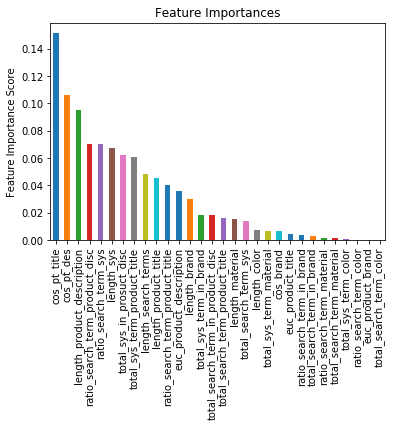

In [55]:
modelfit(regr, y_train, X_train,y_test,X_test)

We can conclude that the result of the Random Forest is worst than the Linear Regression, and the `cos_pt_title` feature (Cosine Similarity on the product title) tends to have the highest score among all the features that we have created. In short, `cos_pt_title` is the most linear feature in our data even though the feature importance score is still low.

The second step and the most important step is tunning our model using the Grid Search Optimizer. However, the Grid Search by itself is not enough, why? Because the Grid search means that you have a set of models which differ from each other in their parameter values, which lie on a grid. What you do is you train each of the models and evaluate it using cross-validation. You then select the parameter that performed best. Again, we need to be careful while growing the tree using the `max_depth`.

### Hyperparameter using the Grid Search

Hyperparameter tuning relies more on experimental results than theory, and thus the best method to determine the optimal settings is to try many different combinations evaluate the performance of each model. However, evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: overfitting.

### Grid Search

First paramter will be the number of estimators or `n_estimators`. What we will do is setting a list of potential estimators in the parameter grid using. We will try all of numbers in the list and output the number that perform the best using the `model_fit()` function. We will set the cross-validation with 5 folds. 

In [56]:
param_test = {'n_estimators':[100,300,500]}
rf1 = GridSearchCV(estimator = RandomForestRegressor(), param_grid=param_test,n_jobs=-1,verbose=0, cv=5)
rf1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


Model Report
RMSE : 0.4738
Coefficient of determination R^2 of the prediction(Score): 0.8801
---------------------------


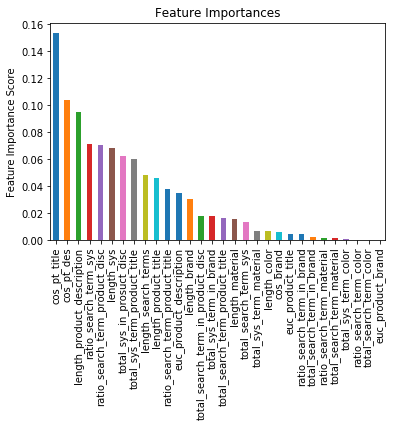

In [57]:
modelfit(rf1.best_estimator_, y_train,X_train,y_test,X_test)

Above is the result of the first hyperparameterization on the `n_estimator` parameter. We lowered the RMSE by 0.0276, which is a good jump. Now let's look at the number of estimators which the Grid Search thinks performs the best so far.

In [58]:
rf1.best_params_

{'n_estimators': 500}

Our optimization says that `n_estimators` equal 500 will perform a low RMSE. So we will take the number 500 and assign it to its parameter in the bellow function.

The second step is to train the model on the `max_depth` parameter as we did with the `n_estimator` paramter.

In [59]:
param_test1 = {'max_depth':[1, 5, 8,10, 15, 20, 25, 30]}
rf2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 500), param_grid=param_test1,n_jobs=-1,verbose=0, cv=5)
rf2.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 5, 8, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


Model Report
RMSE : 0.4694
Coefficient of determination R^2 of the prediction(Score): 0.5561
---------------------------


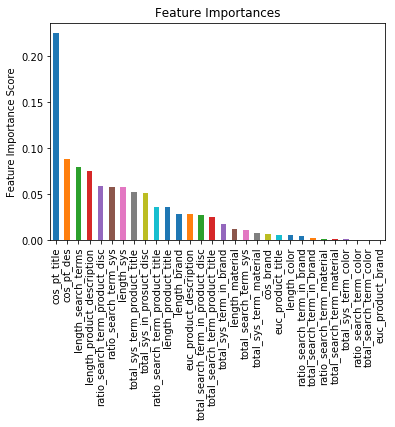

In [60]:
modelfit(rf2.best_estimator_, y_train,X_train,y_test,X_test)

In [61]:
rf2.best_params_

{'max_depth': 15}

Same thing with `min_samples_leaf` parameter.

In [62]:
param_test2 = {"min_samples_leaf" : [1, 2, 4, 6, 8, 10]}
rf3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 500,max_depth=15), param_grid=param_test2,n_jobs=-1,verbose=0, cv=5)
rf3.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


Model Report
RMSE : 0.4692
Coefficient of determination R^2 of the prediction(Score): 0.5015
---------------------------


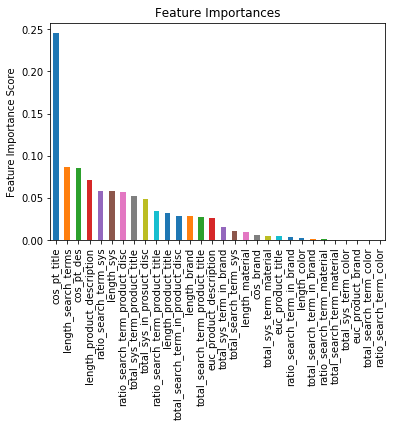

In [63]:
modelfit(rf3.best_estimator_, y_train,X_train,y_test,X_test)

Our new RMSE on the training set is 0.4693. Now, let's figure out how the training will perform on the hidden labels with a third submission on Kaggle.

### Make Estimation on real test data (Hidden labels)

Save the predicted labels into a file for Kaggel submission

In [66]:
#Predicted labels
submission_lr = np.round_(rf3.predict(X_t),decimals=2)
np.savetxt("submission_lr124.csv",submission_lr, delimiter=",")
# A sample of the predicted labels.
rf3.predict(X_t)

array([1.99873354, 2.00628756, 2.07276957, ..., 2.50035634, 2.72187394,
       2.58277988])

### 3rd Submission on Kaggle.

<img src='Capture124.jpg'></img>

As it was expected, the Random Forests model tends to overfit. RMSE on the training set is 0.46 and 0.48 on the test set.

Let's try another model.

### Gradient Boosting Regressor

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

### Define the model

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

### Train the pipeline on training data


Model Report
RMSE : 0.477
Coefficient of determination R^2 of the prediction(Score): 0.2134
---------------------------


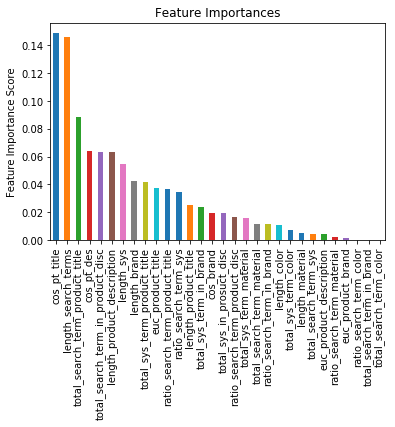

In [68]:
modelfit(gbr,y_train,X_train,y_test,X_test)

**Grid Search**

Tunning the `Gradient Boosting Regressor` model using *Grid Search*.

Same work as we did with the Random Forest Hyperparametrization, we will do the same with the Gradient Booster.

In [69]:
param_booster_test1 = {'n_estimators':[100,300,500]}
gbr1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1), param_grid = param_booster_test1,n_jobs=-1,verbose=0, cv=5)
gbr1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Displaying the grid score best parameters and best score after executing the grid search on `n_estimator` parameter


Model Report
RMSE : 0.4736
Coefficient of determination R^2 of the prediction(Score): 0.2543
---------------------------


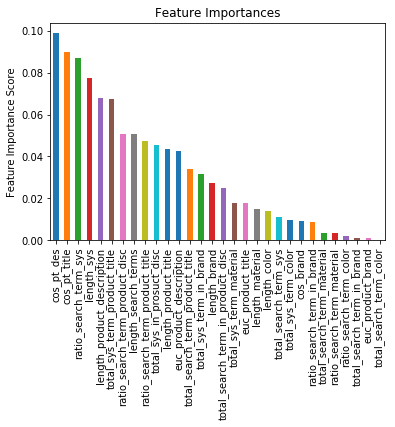

In [70]:
modelfit(gbr1.best_estimator_,y_train,X_train,y_test,X_test)

### Make Estimation on real test data (Hidden labels)

In [71]:
#Predicted labels
submission_lr = np.round_(gbr1.predict(X_t),decimals=2)
np.savetxt("submission_lr125.csv",submission_lr, delimiter=",")
# A sample of the predicted labels.
gbr1.predict(X_t)

array([1.9951907 , 1.99579227, 2.00695735, ..., 2.44336698, 2.6442356 ,
       2.66138224])

### 4th Submission on Kaggle.

<img src='Capture125.jpg'></img>

The good news is that the Gradient Booster overfits less than the Random Forest model. However, tunning the Gradient Booster consumes a lot of time and GPU performance. 

Another model is the XGBoost Regressor, a Kaggle winning-estimator. One of the pros of the XGBoost is that it supports regression as classification problems, has plenty of parameters to adjust its bias/variance or time needed to fit and learn. Which what we are looking the most for. **Time and performance**.

### XGBoost

Below is an example how to use `scikit-learn`'s `RandomizedSearchCV` with XGBoost with some starting distributions.

### Define the model

In [77]:
from xgboost.sklearn import XGBRegressor 
import scipy.stats as st

params = {  
    "n_estimators": st.randint(3, 200),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "gamma": st.uniform(0, 10),
}

and then just plug it into RS.

In [78]:
xgbreg = XGBRegressor(nthreads=-1) 

As you can see, we use `nthreads=-1` and `n_jobs=1`. `nthreads` should be  called n_jobs to follow sklearn conventions, but currently it is not. We explicitly mentioned this here because in the other models we usually set Search's `n_jobs=-1`, but here it would mean that XGBoost would run thread for every CPU + RS would create job for every CPU, effectively wasting cores by switching between N*N processes instead of just N.

### Train the pipeline on training data

In [79]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(xgbreg, params, n_jobs=1)  
gs.fit(X_train, y_train)  

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, nthreads=-1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BB0966F668>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BB0966F978>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BB0966FBA8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BB0966FE48>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_tra


Model Report
RMSE : 0.4706
Coefficient of determination R^2 of the prediction(Score): 0.5169
---------------------------


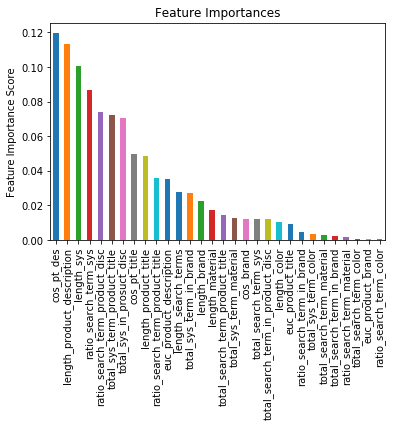

In [80]:
modelfit(gs.best_estimator_,y_train,X_train,y_test,X_test)

In [83]:
#Predicted labels
submission_lr = np.round_(gs.predict(X_t),decimals=2)
np.savetxt("submission_lr128.csv",submission_lr, delimiter=",")
# A sample of the predicted labels.
gs.predict(X_t)

array([2.0260482, 2.1210508, 1.9983585, ..., 2.5652285, 2.6294148,
       2.621131 ], dtype=float32)

### 5th Submission on kaggle

<img src='Capture127.jpg'></img>

Time goes fast with XGBoost. Also the result in the test set is slightly better than the Gradient Boosting Regressor.

### TensorFlow + Keras (Neural Netwrok)

Keras is one of the most popular deep learning libraries in Python for research and development because of its simplicity and ease of use. In fact it strives for minimalism, focusing on only what you need to quickly and simply define and build deep learning models. Also, it provides a convenient wrapper for deep learning models to be used as classification or regression estimators in scikit-learn.

### Define the model and the libraries

In this section we will create a baseline neural network model for the regression problem.

Let’s start off by including all of the functions and objects.

In [84]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

C:\Users\medSr\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Developing a Neural Net using keras on top of TensorFlow  is much easier and more user firendly.

### Train the pipeline on training data¶

**Modeling The Standardized Dataset**

Blow we define a function `create_model()` that create a simple multi-layer neural network for the problem.

In [85]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

We pass this function name to the KerasRegressor class by the `build_fn` argument. We also pass in additional arguments of nb_epoch=50 and batch_size=5. These are automatically bundled up and passed on to the `fit()` function which is called internally by the KerasRegressor class.

In [86]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)

### Train the pipeline on training data

In [87]:
estimator.fit(X_train,y_train)

In [88]:
prediction = estimator.predict(X_test)

In [89]:
#RMSE for the KerasRegressor model
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_test,prediction)))

RMSE: 0.4836


**Evaluate a Deeper Network Topology**

One way to improve the performance a neural network is to add more layers. This might allow the model to extract and recombine higher order features embedded in the data.

In this section we will evaluate the effect of adding one more hidden layer to the model. This is as easy as defining a new function that will create this deeper model, copied from our baseline model above. We can then insert a new line after the first hidden layer. In this case with about half the number of neurons.

In [90]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

We can evaluate this network topology in the same way as above, whilst also using the standardization of the dataset that above was shown to improve performance.

In [91]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=1)))
estimator.fit(X_train,y_train)


In [92]:
prediction1 = estimator.predict(X_test)

In [93]:
#RMSE for the KerasRegressor model
print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_test,prediction1)))

RMSE: 0.4844


### Conclusion

Buyers rely on Home Depot’s product to find and buy the latest products and to get appropriate solutions to their home remodeling needs. When searching for a specific product, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering an enjoyable customer experience are essential. Here where Machine Learning and Big Data come up.  Knowing the preference of our customers is all about data. To offer the best experience, we need to know which product our customer prefers the most.  A lot of data, yes, thanks to the current technology which can allow for a fast processing such as the available cloud services or the Hadoop and Spark ecosystem. Plus, Machine Learning is an exciting, proven concept that allows computers to figure things out for themselves. Instead of every action being explicitly coded by a human which can be costly. 

### Reference

- Wikipedia.com 
- Kaggle.com
- Quora.com
- stackoverflow.com